In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 718.2 kB/s eta 0:00:00


In [ ]:
# !pip install -q kaggle
# !pip install einops
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/ASL/kaggle.json  ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d grassknoted/asl-alphabet
# !unzip -o "/content/asl-alphabet.zip" -d "/content/drive/MyDrive/ASL/asl_alphabet"

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from PIL import Image
from einops import repeat, rearrange
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_dir = "/content/drive/MyDrive/ASL/asl_alphabet/asl_alphabet_train/asl_alphabet_train/"
test_dir = "/content/drive/MyDrive/ASL/asl_alphabet/asl_alphabet_test/asl_alphabet_test/"

In [ ]:
signs = os.listdir(train_dir)
signs.sort()

In [ ]:
# Create data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    classes=signs,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    classes=signs,
    subset='validation'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
imgs, labels = train_generator[0]

In [ ]:
print(imgs.shape, labels.shape)
print(np.min(imgs), np.max(imgs))

(32, 200, 200, 3) (32, 29)
0.0 1.0


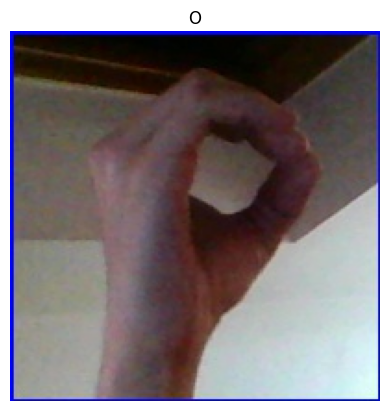

In [ ]:
plt.imshow(imgs[0])
plt.axis("off")
plt.title(signs[np.argmax(labels[0])])
plt.show()

In [ ]:
# Create a MobileNetV2 model
mobilenetv2 = MobileNetV2(input_shape=(200, 200, 3), include_top=False, weights='imagenet')

# add a global spatial average pooling layer
x = mobilenetv2.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer with number of classes
predictions = Dense(len(signs), activation='softmax')(x)

# this is the model we will train
model = Model(inputs=mobilenetv2.input, outputs=predictions)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 100, 100, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 100, 100, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 100, 100, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
# train the model
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

In [ ]:
test_labels = []
test_imgs = []

for file in os.listdir(test_dir):
  test_labels.append(file.split('_')[0])
  test_imgs.append(
      np.asarray(
          Image.open(test_dir + file)
      )/255.0
  )

In [ ]:
test_imgs = np.array(test_imgs)

In [ ]:
predictions = model.predict(test_imgs)
predicted_classes = np.argmax(predictions, axis=1)

# convert true labels to integers using the same transformer as train dataset
label_encoder = LabelEncoder().fit(signs)
true_classes = label_encoder.transform(test_labels)

# evaluate the model
from sklearn.metrics import accuracy_score
print('Test accuracy:', accuracy_score(true_classes, predicted_classes))

In [ ]:
model.save('/content/drive/MyDrive/ASL/asl_alphabet_mobilenet_tf_keras.h5')